# Coautorships

Network analysis

[!!! provisoire, à compléter avec bibliographie]

In [2]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [3]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys
from importlib import reload
import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [ ]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## Get the data from the triplestore

In this first approach we take a relationship between persons just once, even if it can appear several times


One could later on add dates and other more complex information to edges and nodes


In [5]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [6]:
query = """
## Graphe
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf:	<http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX dcterms:	<http://purl.org/dc/terms/>
PREFIX marcrel:	<http://id.loc.gov/vocabulary/relators/>
PREFIX dc11:	<http://purl.org/dc/elements/1.1/>
PREFIX bibo: <http://purl.org/ontology/bibo/>

SELECT ?author_1 (MAX(?persLabel1) as ?pers_1) ?p1 #(MIN(?p1) as ?wd1)
       ?author_2 (MAX(?persLabel2) as ?pers_2) ?p2 #(MIN(?p2) as ?wd2)
       (COUNT(*) as ?n) (GROUP_CONCAT(DISTINCT ?s; separator=" | ") AS ?books) 
                 (MIN(?date) AS ?min_date) (MAX(?date) AS ?max_date)
                 
WHERE {  
  {
  GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/idref.md>
    {
      ## get only books
      {?s rdf:type bibo:Book;
      ## self join
        marcrel:aut ?author_1;
        marcrel:aut ?author_2.

        ?author_1 skos:prefLabel ?persLabel1.
        ?author_2 skos:prefLabel ?persLabel2.  
      
      ## in the context of a self join (?author_1,?author_2)
      # this controls that relationships are kept only once 
      FILTER(  str(?author_1) < str(?author_2)) 
        }
        # dc11:date ?date.
     ### heuristic perspective : missing dates are allowed
     OPTIONAL {?s dc11:date ?date}  
    
     ## verify is author_1 is in the original Wikidata population 
     OPTIONAL {
        GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
                {?p1 wdt:P269 ?author_1.}
     }
     ## verify is author_2 is in the original Wikidata population 
     OPTIONAL {
        GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
                {?p2 wdt:P269 ?author_2.}
     }
      
  
       
      }
    } 
  }
  GROUP BY ?author_1 ?p1 ?author_2 ?p2
"""

In [7]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


83158
[['http://www.idref.fr/03018794X/id',
  'Mahony, Patrick J. (1932-.... ; psychanalyste)',
  '',
  'http://www.idref.fr/03539479X/id',
  'Sulloway, Frank J. (1947-....)',
  '',
  '1',
  'http://www.sudoc.fr/167816349/id',
  '2013',
  '2013'],
 ['http://www.idref.fr/027059898/id',
  'Pasteur, Louis (1822-1895 ; microbiologiste)',
  '',
  'http://www.idref.fr/033383464/id',
  'Mézières, Alfred (1826-1915)',
  '',
  '2',
  'http://www.sudoc.fr/051653907/id | http://www.sudoc.fr/182835332/id',
  '',
  ''],
 ['http://www.idref.fr/13029036X/id',
  'Moura, José M. F. (1946-....)',
  '',
  'http://www.idref.fr/145685675/id',
  'Scharf, Louis L. (19..-....)',
  '',
  '2',
  'http://www.sudoc.fr/046277234/id | http://www.sudoc.fr/005436036/id',
  '',
  '']]


## Inspect the data


In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriP1', 'labelP1', 'wd1', 'uriP2', 'labelP2', 'wd2', 
                'nBooks', 'books', 'min_date','max_date']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  83158


,uriP1,labelP1,wd1,uriP2,labelP2,wd2,nBooks,books,min_date,max_date
10,http://www.idref.fr/027180506/id,"Verdet, Jean-Pierre (1932-....)",http://www.wikidata.org/entity/Q26873921,http://www.idref.fr/029774152/id,"Narcy, Michel (1942-....)",,1,http://www.sudoc.fr/167728245/id,2012,2012
11,http://www.idref.fr/028611624/id,"Ferdière, Alain (1943-....)",,http://www.idref.fr/162166613/id,"Douthe, Mathilde (19..-....)",,2,http://www.sudoc.fr/196260930/id | http://www....,,
12,http://www.idref.fr/172463610/id,"Lösche, M.",,http://www.idref.fr/254139930/id,"Klein, Jacob",,1,http://www.sudoc.fr/008588562/id,1990,1990


In [9]:
### Add column with difference between last and first
# publication year
df_p['diff_years'] = df_p.apply(lambda x : (int(x['max_date'])-int(x['min_date'])) \
                                if x.max_date and x.min_date else None, axis=1)

df_p[df_p.diff_years > 30].iloc[20:25,:]

,uriP1,labelP1,wd1,uriP2,labelP2,wd2,nBooks,books,min_date,max_date,diff_years
3805,http://www.idref.fr/032608373/id,"Strauss, Paul (1852-1942)",,http://www.idref.fr/151309558/id,"Viau, George (1855-1940)",,2,http://www.sudoc.fr/257874755/id | http://www....,1923,2018,95.0
3828,http://www.idref.fr/056816006/id,"Tuffier, Théodore Marin (1857-1929)",,http://www.idref.fr/167932179/id,"Héraud, Gabriel (1839-1922)",,2,http://www.sudoc.fr/023388919/id | http://www....,1902,2008,106.0
4108,http://www.idref.fr/034268235/id,"Lipson, Henry (1910-1991)",http://www.wikidata.org/entity/Q5724969,http://www.idref.fr/071032746/id,"Lipson, Stephen G. (19..-....)",,5,http://www.sudoc.fr/014448645/id | http://www....,1969,2011,42.0
4694,http://www.idref.fr/028341740/id,"Gordon, Peter (1927-....)",,http://www.idref.fr/033207526/id,"Crawfurd, John (1783-1868)",,5,http://www.sudoc.fr/138596727/id | http://www....,1836,2005,169.0
4719,http://www.idref.fr/083347321/id,"Wichterle, Ivan",http://www.wikidata.org/entity/Q95214874,http://www.idref.fr/083439153/id,"Linek, Jan",,8,http://www.sudoc.fr/008063060/id | http://www....,1973,2004,31.0


In [10]:
df_l = pd.DataFrame(df_p.groupby(by='diff_years').size().items())
df_l.columns=['value', 'number']
df_l.head()

,value,number
0,0.0,46382
1,1.0,559
2,2.0,621
3,3.0,183
4,4.0,269


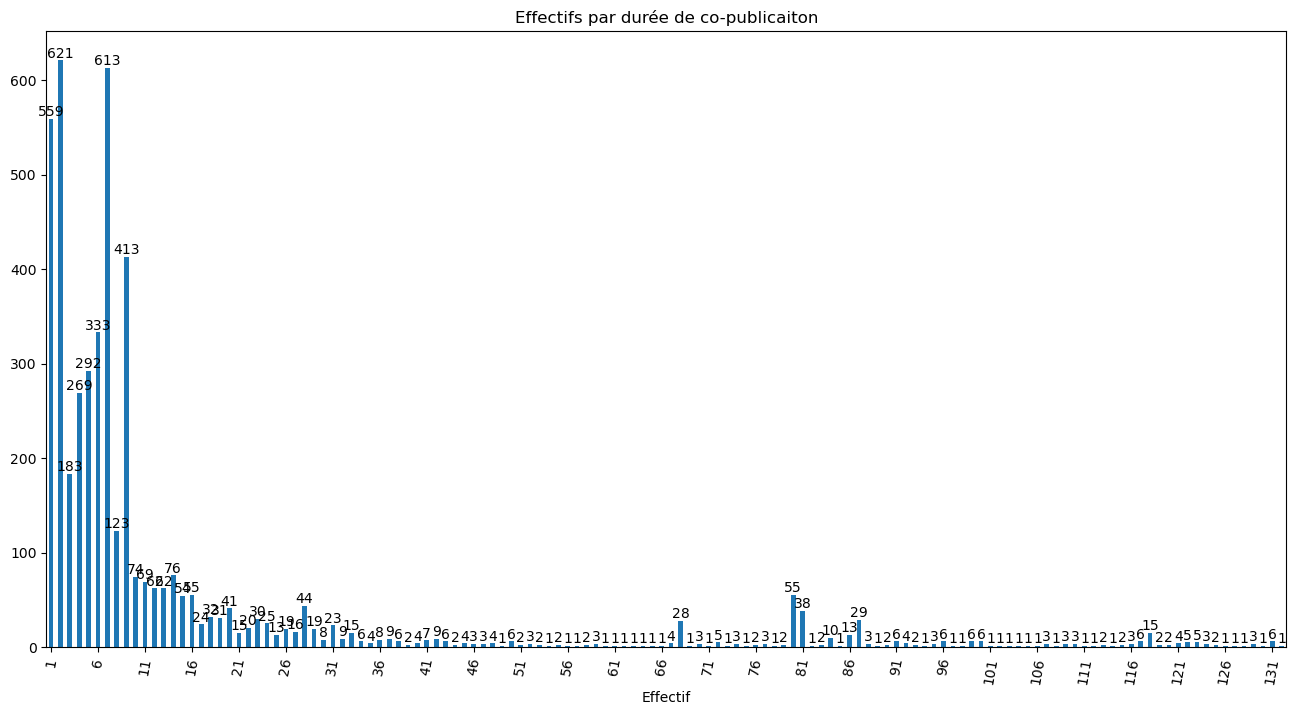

In [11]:
### Bar chart showing distribution: 
# 30 most frequent : .head(30)
ax = df_l.iloc[1: , :]['number']\
    .plot(kind='bar',rot=80, fontsize=10, figsize=(16,8))
#y_labels = reversed(df_l.head(30).label.to_list())
#ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Effectifs par durée de co-publicaiton')
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
plt.show()

In [12]:
### Inspect longer publication periods
# apparemment il s'agit de reéditions
df_p[df_p.diff_years > 110].iloc[20:25,:] 

,uriP1,labelP1,wd1,uriP2,labelP2,wd2,nBooks,books,min_date,max_date,diff_years
13047,http://www.idref.fr/026870908/id,"Fourier, Jean-Baptiste-Joseph (1768-1830)",http://www.wikidata.org/entity/Q8772,http://www.idref.fr/027084396/id,"Ptolémée, Claude (0100?-0170?)",,2,http://www.sudoc.fr/001624237/id | http://www....,1823,1990,167.0
13488,http://www.idref.fr/030356784/id,"Baldinger, Ernst Gottfried (1738-1804)",,http://www.idref.fr/164106022/id,"Suckow, Georg Adolph (1751-1813)",http://www.wikidata.org/entity/Q73824,2,http://www.sudoc.fr/21999238X/id | http://www....,1784,2017,233.0
14060,http://www.idref.fr/133676595/id,"Frochot, Alexis (1832-19..)",,http://www.idref.fr/140880739/id,"Pouriau, Armand Florent (1828-1903)",http://www.wikidata.org/entity/Q105348381,2,http://www.sudoc.fr/252258452/id | http://www....,1868,2020,152.0
14337,http://www.idref.fr/026767724/id,"Carnot, Sadi (1796-1832 ; physicien)",http://www.wikidata.org/entity/Q181685,http://www.idref.fr/029813301/id,"Carnot, Hippolyte (1801-1888)",,3,http://www.sudoc.fr/012490598/id | http://www....,1878,2015,137.0
14483,http://www.idref.fr/028720881/id,"Barré de Saint-Venant, Adhémar-Jean-Claude (17...",,http://www.idref.fr/07335712X/id,"Navier, Claude (1785-1836)",http://www.wikidata.org/entity/Q313512,5,http://www.sudoc.fr/046165223/id | http://www....,1858,2014,156.0


## Graph of coautorships in the base population

In [125]:
### Graph of the copublishing persons in the original Wikidata population
df_cp = df_p[(df_p.wd1.str.len() > 0) & (df_p.wd2.str.len() > 0) ]
print(len(df_cp))
df_cp.head(2)

6863


,uriP1,labelP1,wd1,uriP2,labelP2,wd2,nBooks,books,min_date,max_date,diff_years
7,http://www.idref.fr/026708280/id,"Basdevant, Jean-Louis (1939-2025)",http://www.wikidata.org/entity/Q3166617,http://www.idref.fr/026809583/id,"Dalibard, Jean (1958-.... ; physicien ; profes...",http://www.wikidata.org/entity/Q322711,27,http://www.sudoc.fr/096253096/id | http://www....,,,NaN
30,http://www.idref.fr/031633129/id,"Turner, Michael S (19..-....)",http://www.wikidata.org/entity/Q1372347,http://www.idref.fr/092127339/id,"Lambrecht, Astrid (1967-.... ; physicienne)",http://www.wikidata.org/entity/Q30090384,1,http://www.sudoc.fr/074038079/id,,,NaN


In [126]:
pprint.pprint(df_cp.head(2).to_dict(orient='records'))

[{'books': 'http://www.sudoc.fr/096253096/id | '
           'http://www.sudoc.fr/252227611/id | '
           'http://www.sudoc.fr/033719640/id | '
           'http://www.sudoc.fr/23796466X/id | '
           'http://www.sudoc.fr/198951094/id | '
           'http://www.sudoc.fr/070477612/id | '
           'http://www.sudoc.fr/238717771/id | '
           'http://www.sudoc.fr/194681211/id | '
           'http://www.sudoc.fr/131883402/id | '
           'http://www.sudoc.fr/036028568/id | '
           'http://www.sudoc.fr/060578696/id | '
           'http://www.sudoc.fr/077034031/id | '
           'http://www.sudoc.fr/052183750/id | '
           'http://www.sudoc.fr/236525328/id | '
           'http://www.sudoc.fr/003745791/id | '
           'http://www.sudoc.fr/198937326/id | '
           'http://www.sudoc.fr/198942389/id | '
           'http://www.sudoc.fr/098878557/id | '
           'http://www.sudoc.fr/198912684/id | '
           'http://www.sudoc.fr/198931727/id | '
           'http://w

In [127]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriP1'], e['uriP2'],
     {'freq':e['nBooks'], 'a_debut':e['min_date'], 
      'a_fin':e['max_date'], 'diff':e['diff_years'],
      'books':e['books']}
     )) 
     for e in df_cp.to_dict(orient='records')]
print(len(l))

6863


In [129]:
## Créate the empty graph
G=nx.Graph()

## Add relationships to graph
G.add_edges_from(l)

### Principales caractéristiques de ce graphe
# Noter que le graphe n'est pas connecté, i.e. qu'il y a des ilôts séparés

pprint.pprint({'is_multigraph':G.is_multigraph(), 
       'is_directed':G.is_directed(), 
       'number_of_nodes': G.number_of_nodes(), 
       'number_of_edges':G.number_of_edges(), 
       'is connected':nx.is_connected(G), 
       'density': nx.density(G)}, sort_dicts=False)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3691,
 'number_of_edges': 6863,
 'is connected': False,
 'density': 0.0010077982112793222}


In [130]:
### Inspect edges
pprint.pprint(list(G.edges.data())[:2])

[('http://www.idref.fr/026708280/id',
  'http://www.idref.fr/026809583/id',
  {'a_debut': '',
   'a_fin': '',
   'books': 'http://www.sudoc.fr/096253096/id | '
            'http://www.sudoc.fr/252227611/id | '
            'http://www.sudoc.fr/033719640/id | '
            'http://www.sudoc.fr/23796466X/id | '
            'http://www.sudoc.fr/198951094/id | '
            'http://www.sudoc.fr/070477612/id | '
            'http://www.sudoc.fr/238717771/id | '
            'http://www.sudoc.fr/194681211/id | '
            'http://www.sudoc.fr/131883402/id | '
            'http://www.sudoc.fr/036028568/id | '
            'http://www.sudoc.fr/060578696/id | '
            'http://www.sudoc.fr/077034031/id | '
            'http://www.sudoc.fr/052183750/id | '
            'http://www.sudoc.fr/236525328/id | '
            'http://www.sudoc.fr/003745791/id | '
            'http://www.sudoc.fr/198937326/id | '
            'http://www.sudoc.fr/198942389/id | '
            'http://www.sudoc.fr/0988785

In [ ]:
## Inspect nodes
pprint.pprint(list(G.nodes.data())[:3])

[('http://www.idref.fr/026823055/id', {}),
 ('http://www.idref.fr/112345131/id', {}),
 ('http://www.idref.fr/075501015/id', {})]


### Add metadata to nodes

In [132]:
df_p1 = df_cp[['uriP1','labelP1','wd1']].copy(deep=True)
df_p1 = df_p1.drop_duplicates()
df_p1.columns=['uri', 'label', 'wd']
df_p2 = df_cp[['uriP2','labelP2','wd2']].copy(deep=True)
df_p2 = df_p2.drop_duplicates()
df_p2.columns=['uri', 'label', 'wd']
df_concat = pd.concat([df_p1, df_p2], ignore_index=True)
df_pc = df_concat[['uri', 'label', 'wd']].copy(deep=True)
df_pc = df_pc.drop_duplicates()
print(len(df_pc))
df_pc.sort_values(by='label').head()

3691


,uri,label,wd
789,http://www.idref.fr/075081628/id,"Aarseth, Sverre Johannes (1934-....)",http://www.wikidata.org/entity/Q5996859
1568,http://www.idref.fr/081609183/id,"Abalakin, Viktor Kuzʹmič",http://www.wikidata.org/entity/Q4054292
809,http://www.idref.fr/074654012/id,"Abarbanel, Henry Don Isaac (1943-....)",http://www.wikidata.org/entity/Q110614271
1840,http://www.idref.fr/050313460/id,"Abbadie d'Arrast, Antoine (1810-1897)",http://www.wikidata.org/entity/Q370987
1385,http://www.idref.fr/031602193/id,"Abbe, Cleveland (1838-1916)",http://www.wikidata.org/entity/Q505270


In [133]:
## Nodes without labels
print(len(df_pc[df_pc.label=='']))

0


In [134]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'], 'wd_uri':e['wd']}
     ) for e in df_pc.to_dict(orient='records')])

## Add attributes
nx.set_node_attributes(G, l)
pprint.pprint(list(G.nodes.data())[:4])


[('http://www.idref.fr/026708280/id',
  {'label': 'Basdevant, Jean-Louis (1939-2025)',
   'wd_uri': 'http://www.wikidata.org/entity/Q3166617'}),
 ('http://www.idref.fr/026809583/id',
  {'label': 'Dalibard, Jean (1958-.... ; physicien ; professeur au Collège de '
            'France)',
   'wd_uri': 'http://www.wikidata.org/entity/Q322711'}),
 ('http://www.idref.fr/031633129/id',
  {'label': 'Turner, Michael S (19..-....)',
   'wd_uri': 'http://www.wikidata.org/entity/Q1372347'}),
 ('http://www.idref.fr/092127339/id',
  {'label': 'Lambrecht, Astrid (1967-.... ; physicienne)',
   'wd_uri': 'http://www.wikidata.org/entity/Q30090384'})]


### Inspect degree centrality

In [135]:
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(G)])
nx.set_node_attributes(G, degree)
pprint.pprint(list(G.nodes.data())[:4])

[('http://www.idref.fr/026708280/id',
  {'degree': 4,
   'label': 'Basdevant, Jean-Louis (1939-2025)',
   'wd_uri': 'http://www.wikidata.org/entity/Q3166617'}),
 ('http://www.idref.fr/026809583/id',
  {'degree': 30,
   'label': 'Dalibard, Jean (1958-.... ; physicien ; professeur au Collège de '
            'France)',
   'wd_uri': 'http://www.wikidata.org/entity/Q322711'}),
 ('http://www.idref.fr/031633129/id',
  {'degree': 41,
   'label': 'Turner, Michael S (19..-....)',
   'wd_uri': 'http://www.wikidata.org/entity/Q1372347'}),
 ('http://www.idref.fr/092127339/id',
  {'degree': 11,
   'label': 'Lambrecht, Astrid (1967-.... ; physicienne)',
   'wd_uri': 'http://www.wikidata.org/entity/Q30090384'})]


In [136]:
nx.set_node_attributes(G, degree)
pprint.pp(list(G.nodes.data())[:3])

[('http://www.idref.fr/026708280/id',
  {'label': 'Basdevant, Jean-Louis (1939-2025)',
   'wd_uri': 'http://www.wikidata.org/entity/Q3166617',
   'degree': 4}),
 ('http://www.idref.fr/026809583/id',
  {'label': 'Dalibard, Jean (1958-.... ; physicien ; professeur au Collège de '
            'France)',
   'wd_uri': 'http://www.wikidata.org/entity/Q322711',
   'degree': 30}),
 ('http://www.idref.fr/031633129/id',
  {'label': 'Turner, Michael S (19..-....)',
   'wd_uri': 'http://www.wikidata.org/entity/Q1372347',
   'degree': 41})]


In [137]:
### Inspecter les degrés des personnes:
# on créer ici une liste avec la personne et son degré de centralité,
# c'est-à-dire le nombre d'universités avec lesquelles il a été associé
persons_degree = []
for n in list(G.nodes.data()):
    persons_degree.append([n[0], n[1]['degree']])

## Les degrés de centralité les plus élevés, i.e. fréquentation de plusieurs universités
pprint.pprint(sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10])

[['http://www.idref.fr/032661444/id', 62],
 ['http://www.idref.fr/026984555/id', 58],
 ['http://www.idref.fr/03309618X/id', 57],
 ['http://www.idref.fr/032350589/id', 57],
 ['http://www.idref.fr/086247174/id', 52],
 ['http://www.idref.fr/027092585/id', 52],
 ['http://www.idref.fr/02679344X/id', 47],
 ['http://www.idref.fr/031848591/id', 45],
 ['http://www.idref.fr/027053040/id', 44],
 ['http://www.idref.fr/02873291X/id', 43]]


In [142]:
dp = pd.Series([v[1] for v in persons_degree])
df_l = pd.DataFrame(dp.groupby(by=dp).size().items())
df_l.columns=['value', 'number']
print(df_l.describe())
df_l.head()

           value       number
count  47.000000    47.000000
mean   25.340426    78.531915
std    16.000376   277.348615
min     1.000000     1.000000
25%    12.500000     1.000000
50%    24.000000     6.000000
75%    35.500000    42.000000
max    62.000000  1805.000000


,value,number
0,1,1805
1,2,649
2,3,268
3,4,148
4,5,128


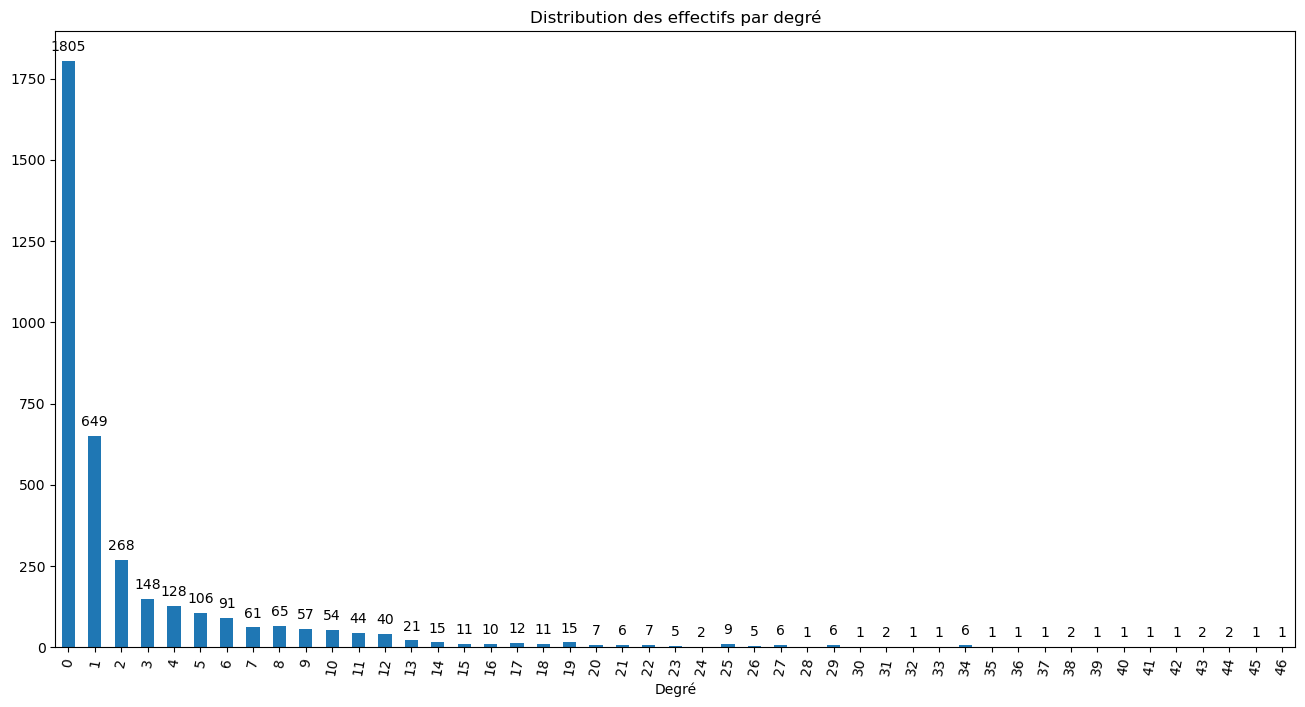

In [151]:
### Bar chart showing distribution: 
# 30 most frequent : .head(30)
ax = df_l.sort_values(by='value').iloc[: , :]['number']\
    .plot(kind='bar',rot=80, fontsize=10, figsize=(16,8))
#y_labels = reversed(df_l.head(30).label.to_list())
#ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1], padding=5 )
plt.xlabel('Degré')
plt.title('Distribution des effectifs par degré')

plt.show()

In [ ]:
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)


In [152]:
### Persons with more than 10 coautors
df_dp = pd.DataFrame(persons_degree)
df_dp.columns=['uri','degree']
df_dp.head()

,uri,degree
0,http://www.idref.fr/026708280/id,4
1,http://www.idref.fr/026809583/id,30
2,http://www.idref.fr/031633129/id,41
3,http://www.idref.fr/092127339/id,11
4,http://www.idref.fr/02669624X/id,10


In [153]:
print(len(df_dp[df_dp.degree > 10]))

313


count    3691.000000
mean        3.718775
std         5.532611
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        62.000000
dtype: float64 

-----
Degree seven and above:
count    313.000000
mean      18.118211
std        9.079532
min       11.000000
25%       12.000000
50%       14.000000
75%       21.000000
max       62.000000
dtype: float64


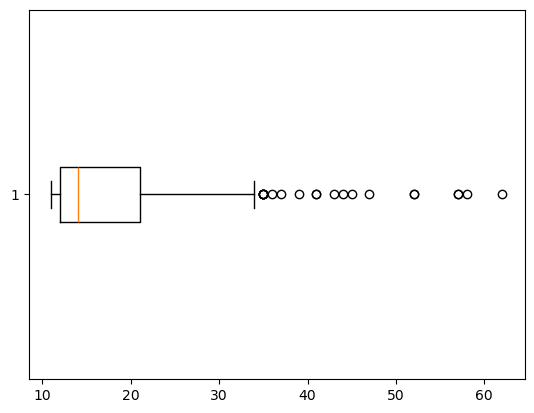

In [154]:
### Distribution des effectifs des degrés

la = [pd[1] for pd in persons_degree]
sa = pd.Series(la)

print(sa.describe(), '\n\n-----\nDegree seven and above:')
print(sa[sa>10].describe())
ax = plt.boxplot(sa[sa>10], vert=False)
plt.show()

### Graph components

In [ ]:
### Créer une variable qui contient la liste des composantes
components = nx.connected_components(G);
components_l = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

## il y a 75 components dans le graphe, et voici le nombre de sommets des premiers 10
# Etant donné que le graphe est bipartite, en dessous de 10 sommets environ les graphes 
# seront très petits ou simplement comportant des personnes isolées,
# comme c'est le cas pour la moitié des traphes ici
print(len(components_l), components_l[:10])

681 [1993, 18, 15, 13, 10, 9, 8, 8, 7, 7]


count     4.000000
mean     14.000000
std       3.366502
min      10.000000
25%      12.250000
50%      14.000000
75%      15.750000
max      18.000000
dtype: float64


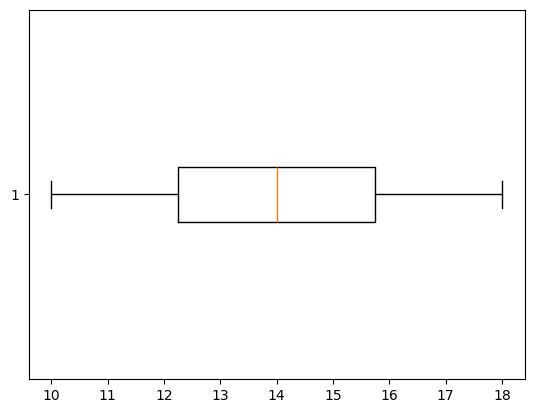

In [156]:
### Distribution des effectifs des graphes

la = components_l[1:]
sa = pd.Series(la)

print(sa[sa>9].describe())
ax = plt.boxplot(sa[sa>9], vert=False)
plt.show()

In [157]:
### Number of components with more than 50 nodes
print(len(sa[sa > 20]))
sa.head()


0


0    18
1    15
2    13
3    10
4     9
dtype: int64

IndexError: index 0 is out of bounds for axis 0 with size 0

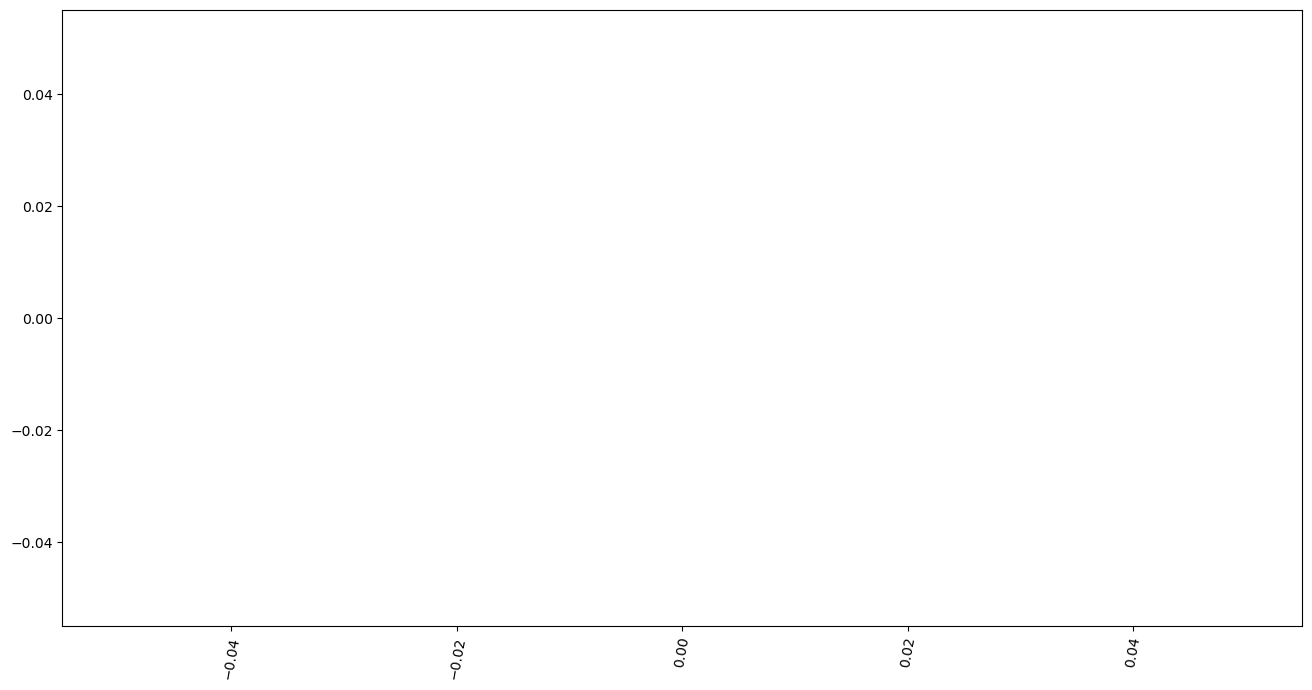

In [158]:
### Bar chart showing distribution: 
# 30 most frequent : .head(30)
ax = sa[sa > 20]\
    .plot(kind='bar',rot=80, fontsize=10, figsize=(16,8))
#y_labels = reversed(df_l.head(30).label.to_list())
#ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1], padding=5 )
plt.xlabel('Degré')
plt.title('Distribution des effectifs par degré')
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
plt.show()

## Inspect larger components

In [159]:


### Créer à partir des sets de sommets qui forment les components un ensemble de sousgraphes
# Ces ensemble de sous-graphes est stocké dans la liste S
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
S[:3]



In [160]:
### i correspond à la position de la composante dans la liste S, len(s.nodes) à l'effectif des sommets
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(ln[:5])


[[0, 1993], [90, 18], [58, 15], [139, 13], [307, 10]]


In [161]:
### 
li = [21,66]
ll = [list(S[i[0]].nodes.data()) for i in ln if i[0] in li ]

 



In [172]:
li = [90]
u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u = nx.union(u, S[i])
print(type(u) )   


<class 'networkx.classes.graph.Graph'>


In [173]:


### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

print(u.is_multigraph(), u.is_directed(), nx.is_connected(u), 
'\n--------'),
print(len([a for a in nx.connected_components(u)]), u.number_of_nodes(), u.number_of_edges(), nx.density(u)
)



False False True 
--------
1 18 26 0.16993464052287582


In [174]:
ln = list(u.nodes.data())
pprint.pprint(ln[:3])

[('http://www.idref.fr/260491675/id',
  {'degree': 3,
   'label': 'Bär, R.',
   'wd_uri': 'http://www.wikidata.org/entity/Q2149159'}),
 ('http://www.idref.fr/133780686/id',
  {'degree': 1,
   'label': 'Ott, Heinrich (1894-1962 ; physicien)',
   'wd_uri': 'http://www.wikidata.org/entity/Q5700284'}),
 ('http://www.idref.fr/260758604/id',
  {'degree': 2,
   'label': 'Brodhun, E.',
   'wd_uri': 'http://www.wikidata.org/entity/Q107987'})]


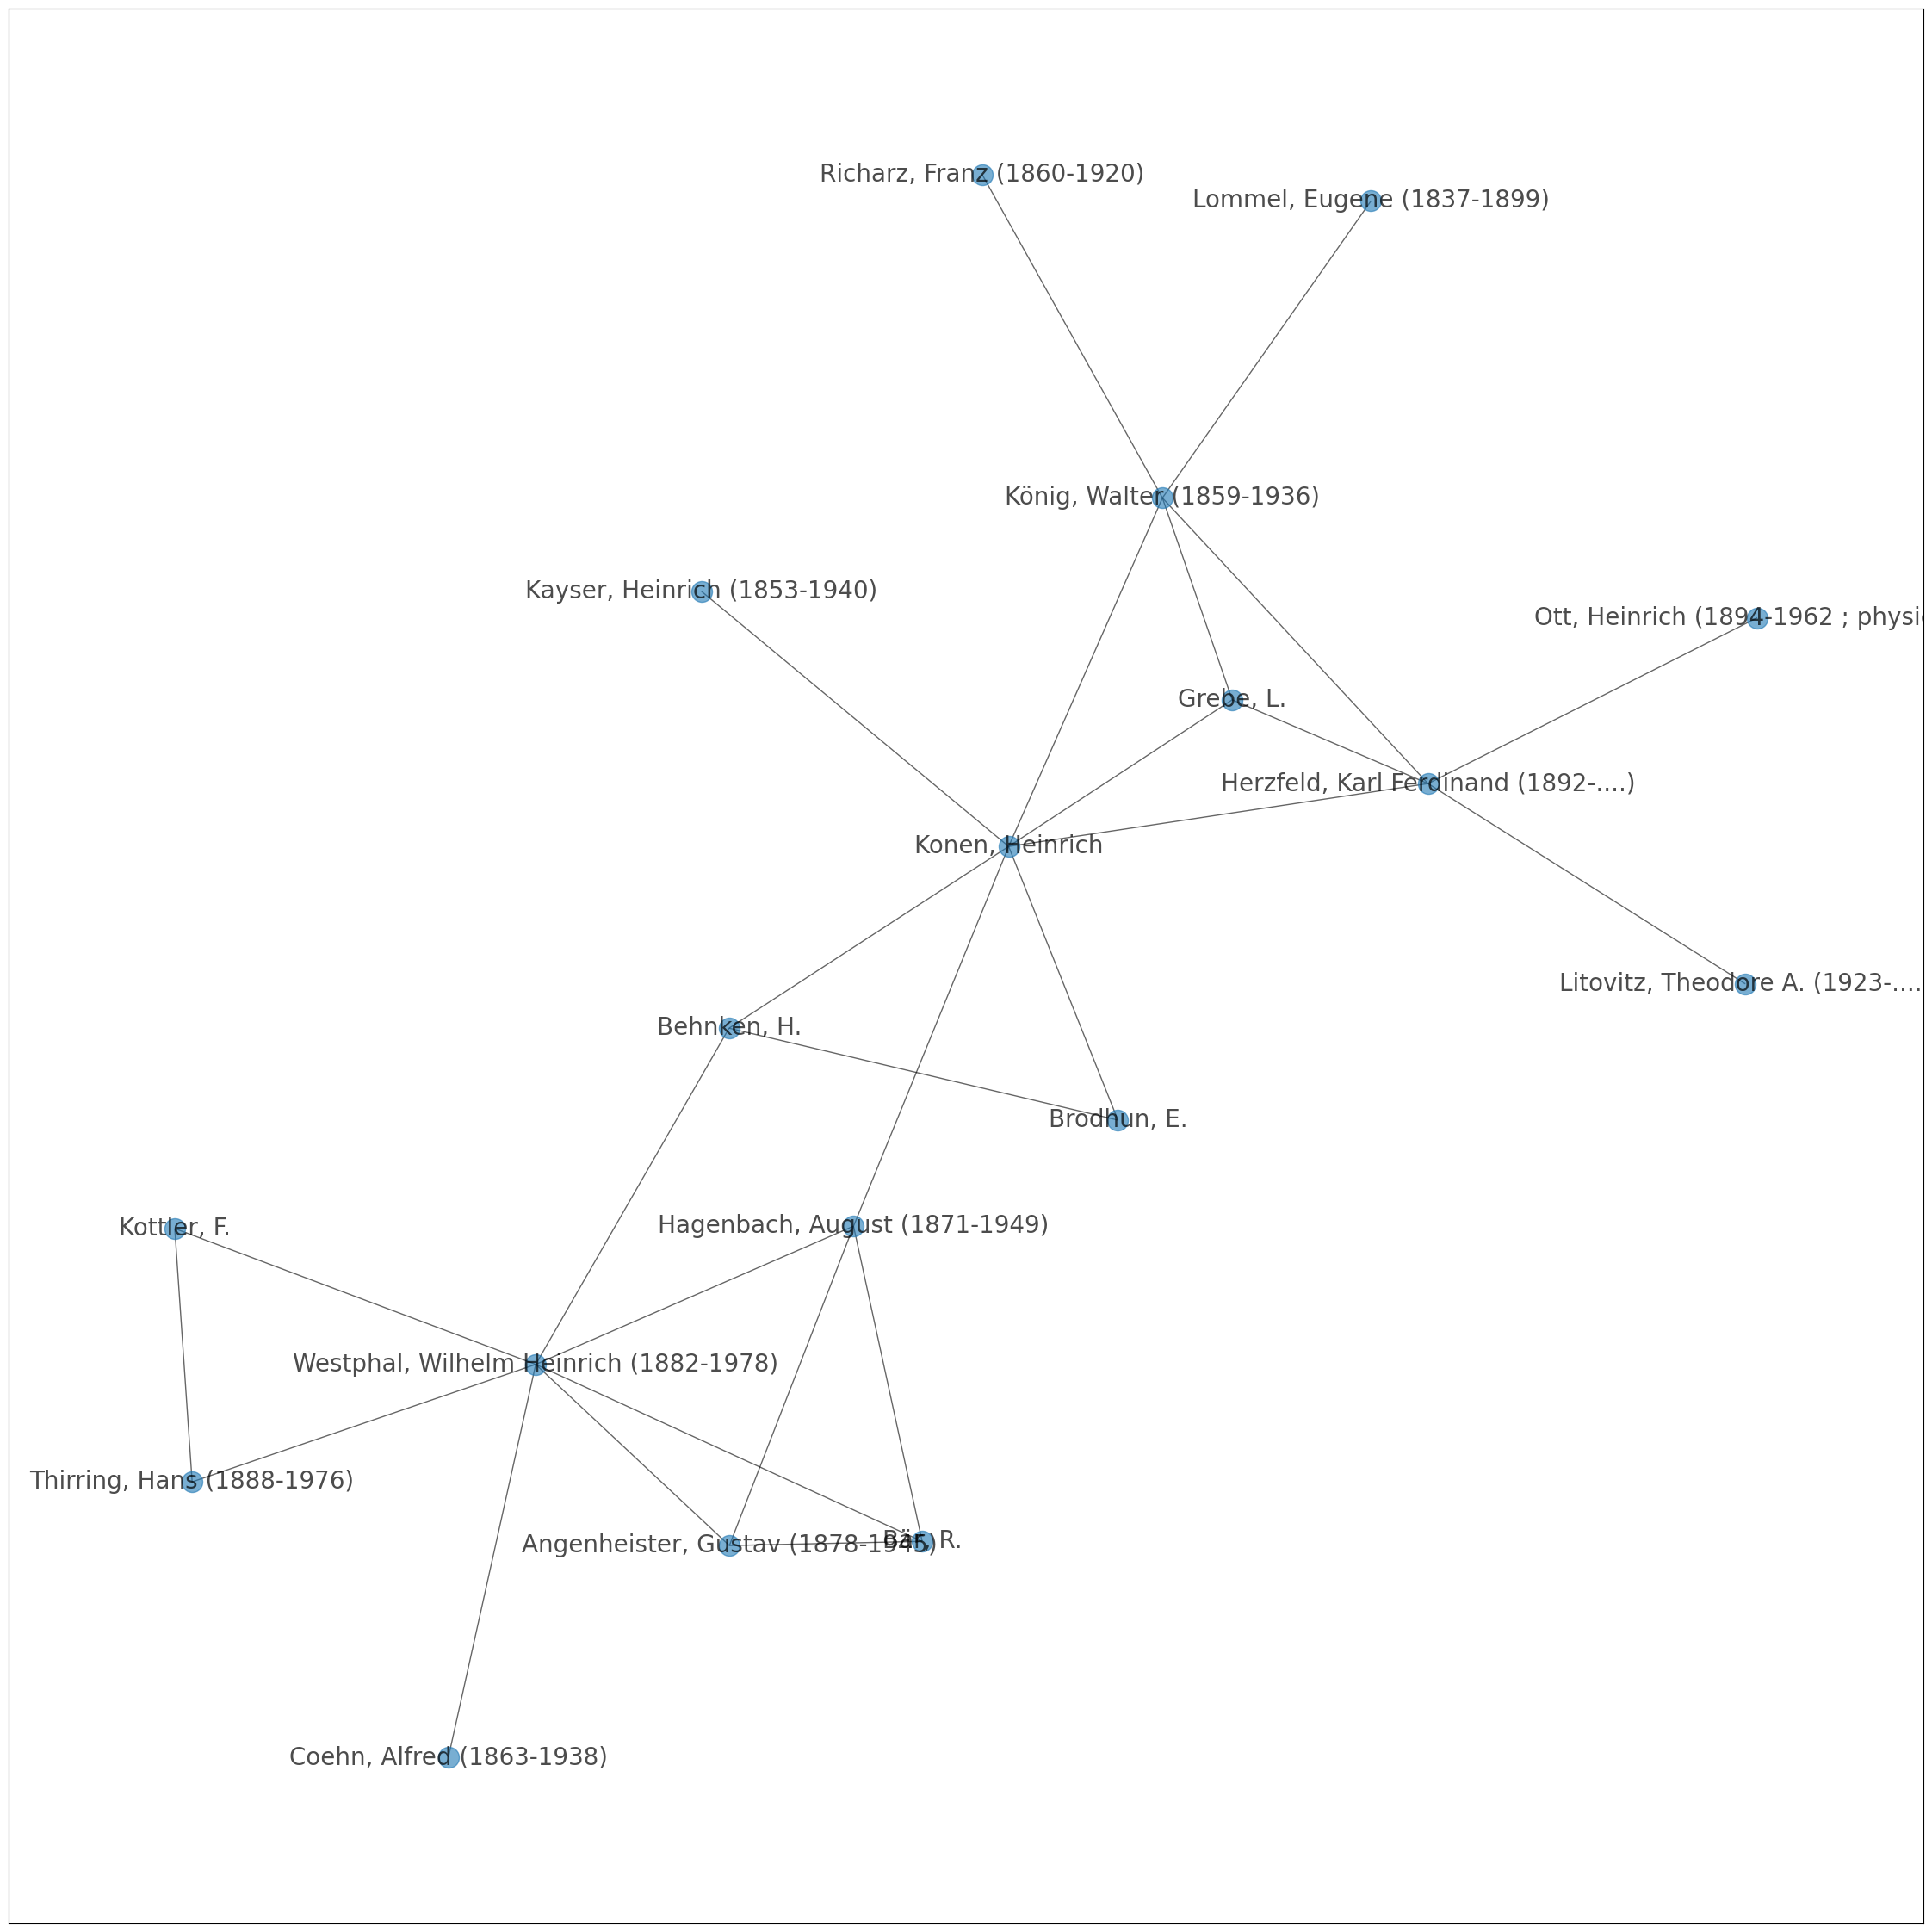

In [198]:
### 

g = u

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))*25

graph_layout = 'kamada_kawai'
n_k = 0.5

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté


node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
#plt.savefig('pictures/composantes_bipartite.jpg')
plt.show()


In [ ]:
pprint.pprint([e for e in u.edges.data()][:1])

[('http://www.idref.fr/190762284/id',
  'http://www.idref.fr/252682009/id',
  {'a_debut': '',
   'a_fin': '',
   'books': 'http://www.sudoc.fr/147663865/id | '
            'http://www.sudoc.fr/248894455/id',
   'diff': nan,
   'freq': '2'})]


In [ ]:
betweenness = nx.betweenness_centrality(g)
nx.set_node_attributes(g, betweenness, 'betweenness')

pprint.pprint([n for n in u.nodes.data()][:3])

[('http://www.idref.fr/190762284/id',
  {'betweenness': 0.0,
   'degree': 46,
   'label': 'Tisserand, Nicolas (19..-.... ; archéologue)',
   'wd_uri': ''}),
 ('http://www.idref.fr/027107000/id',
  {'betweenness': 0.0,
   'degree': 60,
   'label': 'Rolley, Claude (1933-2007 ; archéologue)',
   'wd_uri': ''}),
 ('http://www.idref.fr/24947333X/id',
  {'betweenness': 0.0,
   'degree': 22,
   'label': 'Spantidaki, Youlie (19..-....)',
   'wd_uri': ''})]


In [ ]:
### 


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (50,50))

g = u


node_sizes = [i[1]['betweenness'] * 500000 + 10 for i in list(g.nodes.data())]


## on définit ici l'algorythme avec lequel le traphe sera représenté
#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g, k=0.3)

node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, alpha=0.4)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/idref_smaller_betw.svg')
plt.show()


## Graph of coautorships including all authors and editors of the population books

Dans une optique heuristique on laisse le graphe tel quel

In [13]:
pprint.pprint(df_p.head(2).to_dict(orient='records'))

[{'books': 'http://www.sudoc.fr/147663865/id | '
           'http://www.sudoc.fr/248894455/id',
  'diff_years': nan,
  'labelP1': 'Demarolle, Jeanne-Marie (1936-.... ; historienne)',
  'labelP2': 'Cullin-Mingaud, Magali',
  'max_date': '',
  'min_date': '',
  'nBooks': '2',
  'uriP1': 'http://www.idref.fr/026823055/id',
  'uriP2': 'http://www.idref.fr/112345131/id',
  'wd1': '',
  'wd2': ''},
 {'books': 'http://www.sudoc.fr/007646925/id',
  'diff_years': 0.0,
  'labelP1': 'Revuz, André (1914-2008)',
  'labelP2': 'Conférence sur les problèmes de mesure (1958 ; Paris)',
  'max_date': '1962',
  'min_date': '1962',
  'nBooks': '1',
  'uriP1': 'http://www.idref.fr/075501015/id',
  'uriP2': 'http://www.idref.fr/110784774/id',
  'wd1': '',
  'wd2': ''}]


In [14]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriP1'], e['uriP2'],
     {'freq':e['nBooks'], 'a_debut':e['min_date'], 
      'a_fin':e['max_date'], 'diff':e['diff_years'],
      'books':e['books']}
     )) 
     for e in df_p.to_dict(orient='records')]
print(len(l))

83158


In [15]:
# On crée ici un graphe vide
G=nx.Graph()

In [16]:
### Add relationships to graph
G.add_edges_from(l)

### Principales caractéristiques de ce graphe
# Noter que le graphe n'est pas connecté, i.e. qu'il y a des ilôts séparés

pprint.pprint({'is_multigraph':G.is_multigraph(), 
       'is_directed':G.is_directed(), 
       'number_of_nodes': G.number_of_nodes(), 
       'number_of_edges':G.number_of_edges(), 
       'is connected':nx.is_connected(G), 
       'density': nx.density(G)}, sort_dicts=False)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 21522,
 'number_of_edges': 83158,
 'is connected': False,
 'density': 0.00035907813168881955}


In [17]:
### Inspect edges
pprint.pprint(list(G.edges.data())[:3])

[('http://www.idref.fr/026823055/id',
  'http://www.idref.fr/112345131/id',
  {'a_debut': '',
   'a_fin': '',
   'books': 'http://www.sudoc.fr/147663865/id | '
            'http://www.sudoc.fr/248894455/id',
   'diff': nan,
   'freq': '2'}),
 ('http://www.idref.fr/026823055/id',
  'http://www.idref.fr/026971518/id',
  {'a_debut': '',
   'a_fin': '',
   'books': 'http://www.sudoc.fr/147663865/id | '
            'http://www.sudoc.fr/248894455/id',
   'diff': nan,
   'freq': '2'}),
 ('http://www.idref.fr/026823055/id',
  'http://www.idref.fr/027072304/id',
  {'a_debut': '',
   'a_fin': '',
   'books': 'http://www.sudoc.fr/147663865/id | '
            'http://www.sudoc.fr/248894455/id',
   'diff': nan,
   'freq': '2'})]


In [18]:
## Inspect nodes
pprint.pprint(list(G.nodes.data())[:3])

[('http://www.idref.fr/026823055/id', {}),
 ('http://www.idref.fr/112345131/id', {}),
 ('http://www.idref.fr/075501015/id', {})]


In [19]:
print(list(df_p.columns))

['uriP1', 'labelP1', 'wd1', 'uriP2', 'labelP2', 'wd2', 'nBooks', 'books', 'min_date', 'max_date', 'diff_years']


In [20]:
df_p1 = df_p[['uriP1','labelP1','wd1']].copy(deep=True)
df_p1 = df_p1.drop_duplicates()
df_p1.columns=['uri', 'label', 'wd']
print(len(df_p1))
df_p1.sort_values(by='label').head()

14279


,uri,label,wd
17133,http://www.idref.fr/255484550/id,,
40106,http://www.idref.fr/028513495/id,'Jam mgon kong sprul blo gros mtha' yas (1813-...,
76951,http://www.idref.fr/074207334/id,"ALi, Taan S. El",
46954,http://www.idref.fr/122092821/id,"Aarons, Jules",http://www.wikidata.org/entity/Q22002944
14352,http://www.idref.fr/075081628/id,"Aarseth, Sverre Johannes (1934-....)",http://www.wikidata.org/entity/Q5996859


In [21]:
df_p2 = df_p[['uriP2','labelP2','wd2']].copy(deep=True)
df_p2 = df_p2.drop_duplicates()
df_p2.columns=['uri', 'label', 'wd']
print(len(df_p2))
df_p2.sort_values(by='label').head()

17059


,uri,label,wd
7557,http://www.idref.fr/255484550/id,,
52671,http://www.idref.fr/277053846/id,,
12145,http://www.idref.fr/122092821/id,"Aarons, Jules",http://www.wikidata.org/entity/Q22002944
7573,http://www.idref.fr/075081628/id,"Aarseth, Sverre Johannes (1934-....)",http://www.wikidata.org/entity/Q5996859
1423,http://www.idref.fr/189494379/id,"Aarts, Dirk",


In [22]:
df_concat = pd.concat([df_p1, df_p2], ignore_index=True)
print(len(df_concat))
df_concat.sort_values(by='label').iloc[5:13,:]

31338


,uri,label,wd
11477,http://www.idref.fr/122092821/id,"Aarons, Jules",http://www.wikidata.org/entity/Q22002944
20800,http://www.idref.fr/122092821/id,"Aarons, Jules",http://www.wikidata.org/entity/Q22002944
6418,http://www.idref.fr/075081628/id,"Aarseth, Sverre Johannes (1934-....)",http://www.wikidata.org/entity/Q5996859
19058,http://www.idref.fr/075081628/id,"Aarseth, Sverre Johannes (1934-....)",http://www.wikidata.org/entity/Q5996859
1970,http://www.idref.fr/189494379/id,"Aarts, Dirk",
15562,http://www.idref.fr/189494379/id,"Aarts, Dirk",
4947,http://www.idref.fr/056917155/id,"Aaserud, Finn (19..-.... ; historien des scien...",
3217,http://www.idref.fr/127833730/id,"Abada, Asmâa (19..-.... ; physicienne)",


In [23]:
df_pc = df_concat[['uri', 'label', 'wd']].copy(deep=True)
df_pc = df_pc.drop_duplicates()
print(len(df_pc))
df_pc.sort_values(by='label').head()

21522


,uri,label,wd
28290,http://www.idref.fr/277053846/id,,
7076,http://www.idref.fr/255484550/id,,
10731,http://www.idref.fr/028513495/id,'Jam mgon kong sprul blo gros mtha' yas (1813-...,
13895,http://www.idref.fr/074207334/id,"ALi, Taan S. El",
11477,http://www.idref.fr/122092821/id,"Aarons, Jules",http://www.wikidata.org/entity/Q22002944


In [24]:
# the number of nodes in the graph is the same
print(G.number_of_nodes()) 

21522


In [25]:
print(len(df_pc[df_pc.label=='']))

2


In [26]:
df_pc.loc[7076, 'label'] = 'Owicki, Susan S. (19..-....)'
df_pc.loc[28290, 'label'] = 'Moynihan, Matthew'

In [27]:
df_pc.loc[[7076,28290]]

,uri,label,wd
7076,http://www.idref.fr/255484550/id,"Owicki, Susan S. (19..-....)",
28290,http://www.idref.fr/277053846/id,"Moynihan, Matthew",


In [28]:
df_pc.sort_values(by='label').head()

,uri,label,wd
10731,http://www.idref.fr/028513495/id,'Jam mgon kong sprul blo gros mtha' yas (1813-...,
13895,http://www.idref.fr/074207334/id,"ALi, Taan S. El",
11477,http://www.idref.fr/122092821/id,"Aarons, Jules",http://www.wikidata.org/entity/Q22002944
6418,http://www.idref.fr/075081628/id,"Aarseth, Sverre Johannes (1934-....)",http://www.wikidata.org/entity/Q5996859
1970,http://www.idref.fr/189494379/id,"Aarts, Dirk",


In [29]:
### Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'], 'wd_uri':e['wd']}
     ) for e in df_pc.to_dict(orient='records')])

# Transform to string to verify
print(str(l)[:500])


{'http://www.idref.fr/026823055/id': {'label': 'Demarolle, Jeanne-Marie (1936-.... ; historienne)', 'wd_uri': ''}, 'http://www.idref.fr/075501015/id': {'label': 'Revuz, André (1914-2008)', 'wd_uri': ''}, 'http://www.idref.fr/069714770/id': {'label': 'Bijaoui, Albert (1943-....)', 'wd_uri': 'http://www.wikidata.org/entity/Q2830960'}, 'http://www.idref.fr/032320922/id': {'label': 'Sebesta, Lorenza', 'wd_uri': ''}, 'http://www.idref.fr/02881116X/id': {'label': 'Locqueneux, Robert (1937-.... ; physi


In [30]:
nx.set_node_attributes(G, l)
pprint.pprint(list(G.nodes.data())[:4])


[('http://www.idref.fr/026823055/id',
  {'label': 'Demarolle, Jeanne-Marie (1936-.... ; historienne)', 'wd_uri': ''}),
 ('http://www.idref.fr/112345131/id',
  {'label': 'Cullin-Mingaud, Magali', 'wd_uri': ''}),
 ('http://www.idref.fr/075501015/id',
  {'label': 'Revuz, André (1914-2008)', 'wd_uri': ''}),
 ('http://www.idref.fr/110784774/id',
  {'label': 'Conférence sur les problèmes de mesure (1958 ; Paris)',
   'wd_uri': ''})]


### Inspect degree centrality and components

In [31]:
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(G)])
nx.set_node_attributes(G, degree)
pprint.pprint(list(G.nodes.data())[:4])

[('http://www.idref.fr/026823055/id',
  {'degree': 46,
   'label': 'Demarolle, Jeanne-Marie (1936-.... ; historienne)',
   'wd_uri': ''}),
 ('http://www.idref.fr/112345131/id',
  {'degree': 46, 'label': 'Cullin-Mingaud, Magali', 'wd_uri': ''}),
 ('http://www.idref.fr/075501015/id',
  {'degree': 8, 'label': 'Revuz, André (1914-2008)', 'wd_uri': ''}),
 ('http://www.idref.fr/110784774/id',
  {'degree': 8,
   'label': 'Conférence sur les problèmes de mesure (1958 ; Paris)',
   'wd_uri': ''})]


In [32]:
nx.set_node_attributes(G, degree)
pprint.pp(list(G.nodes.data())[:3])

[('http://www.idref.fr/026823055/id',
  {'label': 'Demarolle, Jeanne-Marie (1936-.... ; historienne)',
   'wd_uri': '',
   'degree': 46}),
 ('http://www.idref.fr/112345131/id',
  {'label': 'Cullin-Mingaud, Magali', 'wd_uri': '', 'degree': 46}),
 ('http://www.idref.fr/075501015/id',
  {'label': 'Revuz, André (1914-2008)', 'wd_uri': '', 'degree': 8})]


In [33]:
### Inspecter les degrés des personnes:
# on créer ici une liste avec la personne et son degré de centralité,
# c'est-à-dire le nombre d'universités avec lesquelles il a été associé
persons_degree = []
for n in list(G.nodes.data()):
    persons_degree.append([n[0], n[1]['degree']])

## Les degrés de centralité les plus élevés, i.e. fréquentation de plusieurs universités
pprint.pprint(sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10])

[['http://www.idref.fr/031038549/id', 206],
 ['http://www.idref.fr/027062112/id', 166],
 ['http://www.idref.fr/03036678X/id', 163],
 ['http://www.idref.fr/027072304/id', 157],
 ['http://www.idref.fr/032661444/id', 157],
 ['http://www.idref.fr/031848591/id', 144],
 ['http://www.idref.fr/026754290/id', 140],
 ['http://www.idref.fr/032350589/id', 134],
 ['http://www.idref.fr/026798417/id', 132],
 ['http://www.idref.fr/03309618X/id', 126]]


In [34]:
dp = pd.Series([v[1] for v in persons_degree])

In [35]:
df_l = pd.DataFrame(dp.groupby(by=dp).size().items())
df_l.columns=['value', 'number']
df_l.head()

,value,number
0,1,6169
1,2,4739
2,3,1950
3,4,1118
4,5,811


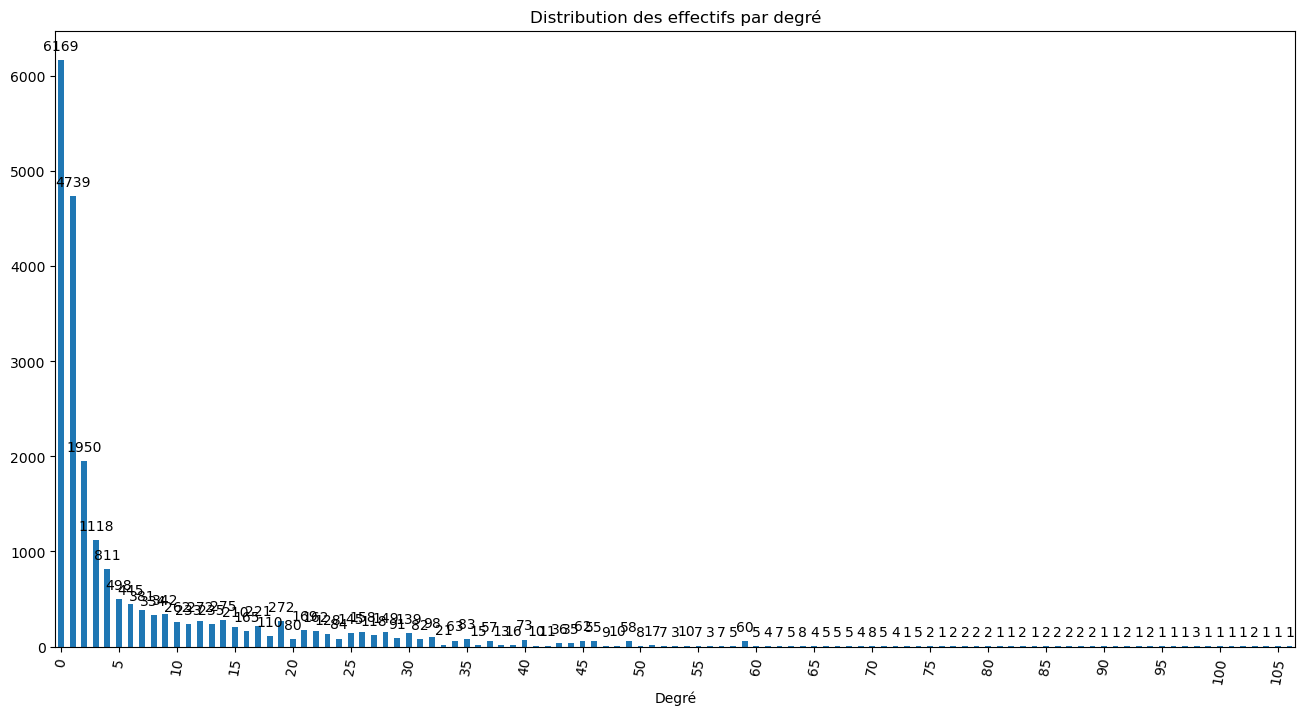

In [36]:
### Bar chart showing distribution: 
# 30 most frequent : .head(30)
ax = df_l.sort_values(by='value').iloc[: , :]['number']\
    .plot(kind='bar',rot=80, fontsize=10, figsize=(16,8))
#y_labels = reversed(df_l.head(30).label.to_list())
#ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1], padding=5 )
plt.xlabel('Degré')
plt.title('Distribution des effectifs par degré')
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
plt.show()

In [37]:
### Persons with more than 10 coautors
df_dp = pd.DataFrame(persons_degree)
df_dp.columns=['uri','degree']
df_dp.head()

,uri,degree
0,http://www.idref.fr/026823055/id,46
1,http://www.idref.fr/112345131/id,46
2,http://www.idref.fr/075501015/id,8
3,http://www.idref.fr/110784774/id,8
4,http://www.idref.fr/069714770/id,14


In [38]:
print(len(df_dp[df_dp.degree > 10]))

4735


count    21522.00000
mean         7.72772
std         11.96736
min          1.00000
25%          1.00000
50%          2.00000
75%          9.00000
max        206.00000
dtype: float64 

-----
Degree seven and above:
count    4735.000000
mean       25.494192
std        15.129993
min        11.000000
25%        15.000000
50%        22.000000
75%        31.000000
max       206.000000
dtype: float64


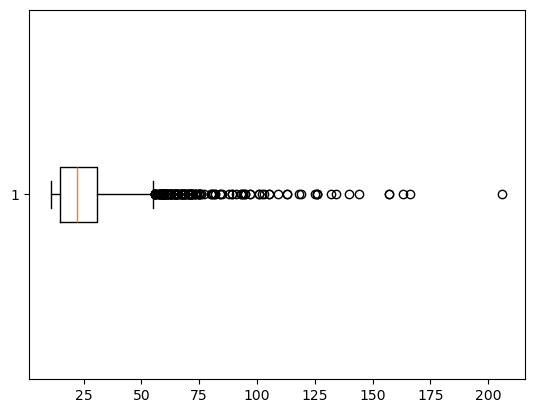

In [39]:
### Distribution des effectifs des degrés

la = [pd[1] for pd in persons_degree]
sa = pd.Series(la)

print(sa.describe(), '\n\n-----\nDegree seven and above:')
print(sa[sa>10].describe())
ax = plt.boxplot(sa[sa>10], vert=False)
plt.show()

In [40]:
### Créer une variable qui contient la liste des composantes
components = nx.connected_components(G);
components_l = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

## il y a 75 components dans le graphe, et voici le nombre de sommets des premiers 10
# Etant donné que le graphe est bipartite, en dessous de 10 sommets environ les graphes 
# seront très petits ou simplement comportant des personnes isolées,
# comme c'est le cas pour la moitié des traphes ici
print(len(components_l), components_l[:10])

2873 [11209, 158, 53, 53, 47, 46, 44, 39, 37, 37]


count    106.000000
mean      18.783019
std       16.667050
min       10.000000
25%       11.000000
50%       14.000000
75%       19.000000
max      158.000000
dtype: float64


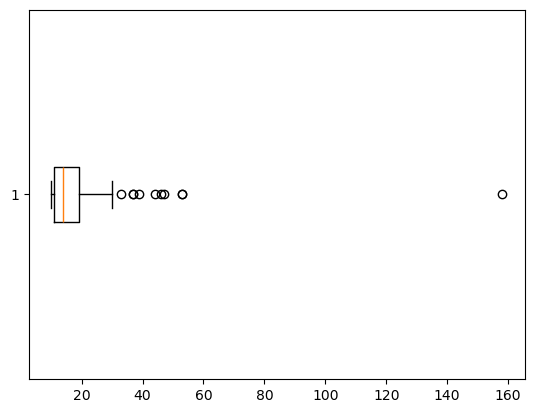

In [41]:
### Distribution des effectifs des graphes

la = components_l[1:]
sa = pd.Series(la)

print(sa[sa>9].describe())
ax = plt.boxplot(sa[sa>9], vert=False)
plt.show()

In [42]:
### Number of components with more than 50 nodes
print(len(sa[sa > 20]))
sa.head()


24


0    158
1     53
2     53
3     47
4     46
dtype: int64

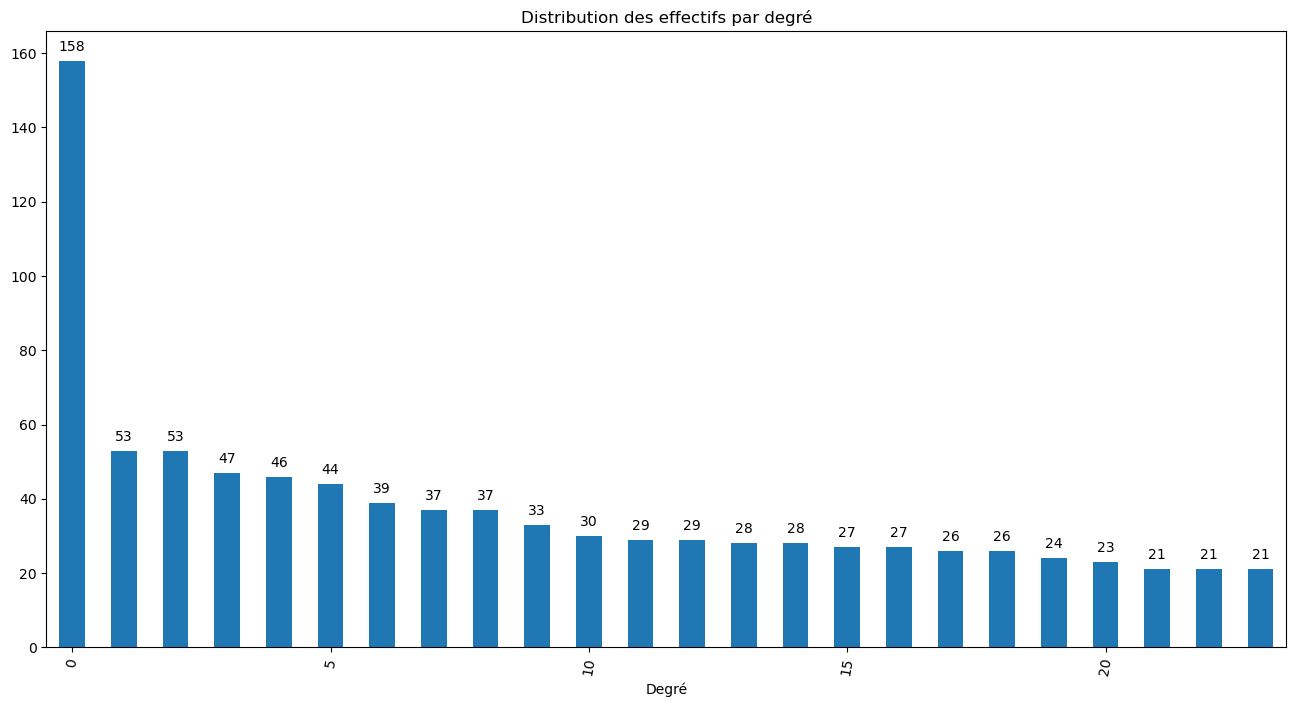

In [43]:
### Bar chart showing distribution: 
# 30 most frequent : .head(30)
ax = sa[sa > 20]\
    .plot(kind='bar',rot=80, fontsize=10, figsize=(16,8))
#y_labels = reversed(df_l.head(30).label.to_list())
#ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1], padding=5 )
plt.xlabel('Degré')
plt.title('Distribution des effectifs par degré')
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
plt.show()

## Inspect larger components

In [44]:


### Créer à partir des sets de sommets qui forment les components un ensemble de sousgraphes
# Ces ensemble de sous-graphes est stocké dans la liste S
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
S[:3]



In [45]:
### i correspond à la position de la composante dans la liste S, len(s.nodes) à l'effectif des sommets
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(ln[:5])


[[1, 11209], [0, 158], [21, 53], [66, 53], [5, 47]]


In [46]:
### 
li = [21,66]
ll = [list(S[i[0]].nodes.data()) for i in ln if i[0] in li ]

 



In [47]:
li = [0]
u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u = nx.union(u, S[i])
print(type(u) )   


<class 'networkx.classes.graph.Graph'>


In [48]:


### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

print(u.is_multigraph(), u.is_directed(), nx.is_connected(u), 
'\n--------'),
print(len([a for a in nx.connected_components(u)]), u.number_of_nodes(), u.number_of_edges(), nx.density(u)
)



False False True 
--------
1 158 3377 0.2722728372168024


In [116]:
ln = list(u.nodes.data())
pprint.pprint(ln[:3])

[('http://www.idref.fr/073410578/id',
  {'betweenness': 0.0,
   'degree': 36,
   'label': 'Bourigault, Didier',
   'wd_uri': ''}),
 ('http://www.idref.fr/152400842/id',
  {'betweenness': 0.0, 'degree': 47, 'label': 'Cerullo, Maria', 'wd_uri': ''}),
 ('http://www.idref.fr/027003108/id',
  {'betweenness': 0.0033976052020199756,
   'degree': 41,
   'label': 'Maitte, Bernard (1942-....)',
   'wd_uri': 'http://www.wikidata.org/entity/Q18288897'})]


In [ ]:
### 


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (50,50))

g = u

## on définit ici l'algorythme avec lequel le traphe sera représenté
#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g, k=0.3)

node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
#plt.savefig('pictures/composantes_bipartite.jpg')
plt.show()


In [52]:
pprint.pprint([e for e in u.edges.data()][:1])

[('http://www.idref.fr/190762284/id',
  'http://www.idref.fr/252682009/id',
  {'a_debut': '',
   'a_fin': '',
   'books': 'http://www.sudoc.fr/147663865/id | '
            'http://www.sudoc.fr/248894455/id',
   'diff': nan,
   'freq': '2'})]


In [53]:
betweenness = nx.betweenness_centrality(g)
nx.set_node_attributes(g, betweenness, 'betweenness')

pprint.pprint([n for n in u.nodes.data()][:3])

[('http://www.idref.fr/190762284/id',
  {'betweenness': 0.0,
   'degree': 46,
   'label': 'Tisserand, Nicolas (19..-.... ; archéologue)',
   'wd_uri': ''}),
 ('http://www.idref.fr/027107000/id',
  {'betweenness': 0.0,
   'degree': 60,
   'label': 'Rolley, Claude (1933-2007 ; archéologue)',
   'wd_uri': ''}),
 ('http://www.idref.fr/24947333X/id',
  {'betweenness': 0.0,
   'degree': 22,
   'label': 'Spantidaki, Youlie (19..-....)',
   'wd_uri': ''})]


In [ ]:
### 


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (50,50))

g = u


node_sizes = [i[1]['betweenness'] * 500000 + 10 for i in list(g.nodes.data())]


## on définit ici l'algorythme avec lequel le traphe sera représenté
#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g, k=0.3)

node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, alpha=0.4)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/idref_smaller_betw.svg')
plt.show()


### Inspect the biggest graph

In [55]:
li = [1]
u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u = nx.union(u, S[i])
print(type(u) )   


<class 'networkx.classes.graph.Graph'>


In [56]:


### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

print(u.is_multigraph(), u.is_directed(), nx.is_connected(u), 
'\n--------'),
print(len([a for a in nx.connected_components(u)]), u.number_of_nodes(), u.number_of_edges(), nx.density(u)
)



False False True 
--------
1 11209 61980 0.00098670328962865


In [81]:
lh = [n[0] for n in u.nodes.data() if n[1]['degree']> 20]  # test with 10, 20 etc.
print(len(lh), lh[:3])
H = u.subgraph(lh)

1989 ['http://www.idref.fr/073410578/id', 'http://www.idref.fr/152400842/id', 'http://www.idref.fr/027003108/id']


In [82]:


### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

print(H.is_multigraph(), H.is_directed(), nx.is_connected(H), 
'\n--------'),
print(len([a for a in nx.connected_components(H)]), H.number_of_nodes(), H.number_of_edges(), nx.density(H)
)



False False False 
--------
6 1989 28347 0.014337912846612101


In [83]:


### Créer à partir des sets de sommets qui forment les components un ensemble de sousgraphes
# Ces ensemble de sous-graphes est stocké dans la liste S
S = [H.subgraph(c).copy() for c in nx.connected_components(H)]

### i correspond à la position de la composante dans la liste S, len(s.nodes) à l'effectif des sommets
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(ln[:5])


[[0, 1982], [2, 3], [1, 1], [3, 1], [4, 1]]


In [84]:
### 
li = [0]
ll = [list(S[i[0]].nodes.data()) for i in ln if i[0] in li ]
pprint.pprint(ll[0][:3])

 



[('http://www.idref.fr/073410578/id',
  {'betweenness': 0.0,
   'degree': 36,
   'label': 'Bourigault, Didier',
   'wd_uri': ''}),
 ('http://www.idref.fr/152400842/id',
  {'betweenness': 0.0, 'degree': 47, 'label': 'Cerullo, Maria', 'wd_uri': ''}),
 ('http://www.idref.fr/027003108/id',
  {'betweenness': 0.002447267791910923,
   'degree': 41,
   'label': 'Maitte, Bernard (1942-....)',
   'wd_uri': 'http://www.wikidata.org/entity/Q18288897'})]


In [85]:
li = [0]
u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u = nx.union(u, S[i])
print(type(u) )   


<class 'networkx.classes.graph.Graph'>


In [86]:


### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

print(u.is_multigraph(), u.is_directed(), nx.is_connected(u), 
'\n--------'),
print(len([a for a in nx.connected_components(u)]), u.number_of_nodes(), u.number_of_edges(), nx.density(u)
)



False False True 
--------
1 1982 28344 0.01443786608502265


In [87]:
print([u.nodes.data()][:3])

[NodeDataView({'http://www.idref.fr/073410578/id': {'label': 'Bourigault, Didier', 'wd_uri': '', 'degree': 36, 'betweenness': 0.0}, 'http://www.idref.fr/152400842/id': {'label': 'Cerullo, Maria', 'wd_uri': '', 'degree': 47, 'betweenness': 0.0}, 'http://www.idref.fr/027003108/id': {'label': 'Maitte, Bernard (1942-....)', 'wd_uri': 'http://www.wikidata.org/entity/Q18288897', 'degree': 41, 'betweenness': 0.002447267791910923}, 'http://www.idref.fr/034638776/id': {'label': 'Violle, Jules (1841-1923)', 'wd_uri': 'http://www.wikidata.org/entity/Q716352', 'degree': 44, 'betweenness': 0.0}, 'http://www.idref.fr/249758768/id': {'label': 'Nieto, Joseph (19..-....)', 'wd_uri': '', 'degree': 50, 'betweenness': 0.0}, 'http://www.idref.fr/030487196/id': {'label': 'Neveu, André (1946-....)', 'wd_uri': 'http://www.wikidata.org/entity/Q325967', 'degree': 43, 'betweenness': 0.0018782885270253109}, 'http://www.idref.fr/118753703/id': {'label': 'Baldini, Ugo (1943-....)', 'wd_uri': '', 'degree': 24, 'betw

### Inspect betweenness

In [88]:
betweenness = nx.betweenness_centrality(u)
nx.set_node_attributes(u, betweenness, 'betweenness')

pprint.pprint([n for n in u.nodes.data()][:3])

[('http://www.idref.fr/073410578/id',
  {'betweenness': 0.0,
   'degree': 36,
   'label': 'Bourigault, Didier',
   'wd_uri': ''}),
 ('http://www.idref.fr/152400842/id',
  {'betweenness': 0.0, 'degree': 47, 'label': 'Cerullo, Maria', 'wd_uri': ''}),
 ('http://www.idref.fr/027003108/id',
  {'betweenness': 0.0033976052020199756,
   'degree': 41,
   'label': 'Maitte, Bernard (1942-....)',
   'wd_uri': 'http://www.wikidata.org/entity/Q18288897'})]


In [99]:
###
# 
persons_betweenness = []
for n in list(u.nodes.data()):
    persons_betweenness.append([n[0], n[1]['betweenness']])

## Les degrés de centralité les plus élevés, i.e. fréquentation de plusieurs universités
pprint.pprint(sorted(persons_betweenness, key = lambda x : x[1], reverse=True)[:10])

[['http://www.idref.fr/027062112/id', 0.105005261643795],
 ['http://www.idref.fr/026988518/id', 0.08988774984010477],
 ['http://www.idref.fr/026920735/id', 0.07847276398513148],
 ['http://www.idref.fr/026798417/id', 0.07618148793051865],
 ['http://www.idref.fr/026796708/id', 0.07238496044744779],
 ['http://www.idref.fr/03036678X/id', 0.07070435069540669],
 ['http://www.idref.fr/031038549/id', 0.06998588976101264],
 ['http://www.idref.fr/026984555/id', 0.060021436523637735],
 ['http://www.idref.fr/032350589/id', 0.05682713193352213],
 ['http://www.idref.fr/026989743/id', 0.05336155434120563]]


In [98]:
ln = [n[0] for n in sorted(persons_betweenness, key = lambda x : x[1], reverse=True)[:50]]
pprint.pprint(ln[:5])

['http://www.idref.fr/027062112/id',
 'http://www.idref.fr/026988518/id',
 'http://www.idref.fr/026920735/id',
 'http://www.idref.fr/026798417/id',
 'http://www.idref.fr/026796708/id']


In [95]:
node_sizes = [i[1]['betweenness'] * 100000 + 10 for i in list(u.nodes.data())]
print(node_sizes[:3])

[10.0, 10.0, 349.76052020199756]


In [ ]:
node_sizes = [i[1]['betweenness'] * 100000 + 10 for i in list(u.nodes.data())]
print(node_sizes[:3])

[10.0, 10.0, 349.76052020199756]


In [114]:
node_sizes = [n[1]* 100000 + 10 if n[0] in ln else 10 
            for n in persons_betweenness]
print(node_sizes[:3])
print(len(node_sizes))

[10, 10, 10]
1982


In [112]:
node_labels = dict([tuple(( n[0] , n[1]['label'] ))
                    if n[0] in ln else tuple(( n[0] , ' ' ))
                    for n in u.nodes.data()])
print(str(node_labels)[:300])

{'http://www.idref.fr/073410578/id': ' ', 'http://www.idref.fr/152400842/id': ' ', 'http://www.idref.fr/027003108/id': ' ', 'http://www.idref.fr/034638776/id': ' ', 'http://www.idref.fr/249758768/id': ' ', 'http://www.idref.fr/030487196/id': ' ', 'http://www.idref.fr/118753703/id': ' ', 'http://www.


In [ ]:
### 


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (100,100))

g = u





## on définit ici l'algorythme avec lequel le traphe sera représenté
pos = nx.kamada_kawai_layout(g)
#pos = nx.spring_layout(g)




### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos, node_size=node_sizes,  alpha=0.3)
nx.draw_networkx_edges(g, pos, alpha=0.2) # edgelist=ln, edge_color=c, 
#nx.draw_networkx_nodes(g, pos, nodelist=ln, node_size=node_sizes, alpha=0.5)
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.9, font_size=20)


### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/idref_big_betw_2.svg')


plt.close()
#plt.show()


## Conclusion (provisoire)

* On observe deux types de liens: ceux qui dépendent des publications dans collectifs et actes de colloques et les autres.
  * Il faut définir une méthode pour séparer les deux car ce sont deux logiques différentes
  * On observe aussi des 'passeurs' dont il faudra mieux étudier le profil
* Il y a aussi les liens entre éditeurs et auteurs qui n'ont pas été pris en compte, et qui 
